# ADVANCED CLASSIFICATION

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from scikitplot.metrics import plot_roc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.cof import COF
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC

In [2]:
def training_pulito(df_train_csv):
    selected = ['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
 'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
 'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
 'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
 'sc_skew_w4','stft_sum_w4','stft_kur_w4']

    df_selected = df_train_csv[selected]
    emotion_train = df_train_csv['emotion']
    
    df_train_sel, df_test_sel, emotion_train_train, emotion_train_test = train_test_split(
        df_selected, emotion_train, test_size=0.3, random_state=0)
        
    ## outlier detection 
    # normalizzazione
    sc = StandardScaler()
    df_norm = sc.fit_transform(df_selected)  # normalizzato intero 

    # sc.fit(df_train_sel)
    # df_train_sel_norm=sc.transform(df_train_sel)  # normalizzato a pezzi
    # df_test_sel_norm=sc.transform(df_test_sel)

    # LOF
    clf=LocalOutlierFactor(n_neighbors=190)
    lof_outliers = clf.fit_predict(df_norm) 
    out_lof=np.where(lof_outliers==-1)

    # COF 
    cof_=COF(n_neighbors=20)
    cof_outliers = cof_.fit_predict(df_norm) 
    out_cof=np.where(cof_outliers==1)

    # ABOD
    clf = ABOD(0.02)  # contamination = 0.02
    clf.fit(df_norm)
    out_abod = np.where(clf.labels_ == 1)

    # ISOLATION FOREST 
    clf = IsolationForest(random_state=0 )
    clf.fit(df_selected)
    clf.predict(df_selected)
    if_outliers = clf.predict(df_selected)
    if_outliers #For each observation, tells whether or not (+1 or -1) it should be considered as an inlier according to the fitted model.
    #-1 sono outliers 
    out_if=np.where(if_outliers==-1)

    #qua trasformiamo tutto il lista per applicare la funzione counter
    out_lof_list = (out_lof[0]).tolist()
    out_cof_list = (out_cof[0]).tolist()
    out_if_list = (out_if[0]).tolist()
    out_abod_list = (out_abod[0]).tolist()

    outliers_lista = out_lof_list + out_cof_list + out_if_list + out_abod_list # lista di tutte le osservazioni outliers
    diz = Counter(outliers_lista) # contiamo quante volte si ripetono gli outliers nei 4 metodi 
    mega_outliers=[] # lista che riempiamo con gli outliers che si ripetono per almeno 3 volte 
    for el in diz:
        if diz[el]>=3:
            mega_outliers.append(el)

    selected_and_cat=['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    
    df_final_cat = df_train_csv[selected_and_cat]

    df_final = df_selected.drop(mega_outliers)   #rimozione dei mega outliers dal dataset 
    df_final_cat = df_final_cat.drop(mega_outliers)

    # df_final è numerico
    #df_final_cat è intero sia cat che num 
    return df_final, df_final_cat

In [3]:
# questa funzione ritorna il test set con le stesse colonne selezionate nel training set
def test_pulito(df):
    selected = ['kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur','sc_q50','stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2',
   'mfcc_sum_w2','mfcc_std_w2', 'mfcc_q01_w2' ,'mfcc_q05_w2', 'mfcc_q99_w2', 'mfcc_kur_w2', 'mfcc_skew_w2' ,'sc_q05_w2', 'sc_q25_w2', 'sc_q50_w2',
   'sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3','lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3',
   'sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3','stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_q50_w4',
   'sc_skew_w4','stft_sum_w4','stft_kur_w4']
   
    selected_and_cat=['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex','filename','kur', 'lag1_kur', 'mfcc_q05', 'mfcc_q95', 'mfcc_kur', 'sc_q50',
    'sc_q75', 'stft_sum','kur_w1','lag1_kur_w1','mfcc_std_w1','mfcc_q99_w1','sc_std_w1','kur_w2','zc_sum_w2','mfcc_sum_w2','mfcc_std_w2','mfcc_q01_w2','mfcc_q05_w2',
    'mfcc_q99_w2','mfcc_kur_w2','mfcc_skew_w2','sc_q05_w2','sc_q25_w2','sc_q50_w2','sc_q99_w2','sc_kur_w2','sc_skew_w2','stft_sum_w2','kur_w3',
    'lag1_skew_w3','zc_sum_w3','mfcc_sum_w3','mfcc_mean_w3','mfcc_q01_w3','mfcc_q25_w3','mfcc_kur_w3','sc_std_w3','sc_min_w3','sc_q01_w3','sc_q50_w3','sc_q95_w3','stft_sum_w3',
    'stft_kur_w3','kur_w4','lag1_kur_w4','lag1_skew_w4','mfcc_max_w4','mfcc_q95_w4','mfcc_q99_w4','sc_sum_w4','sc_min_w4','sc_skew_w4','stft_sum_w4','stft_kur_w4']
    
    df_test_numerico = df[selected]
    df_test_num_cat = df[selected_and_cat]
    
    return df_test_numerico, df_test_num_cat

In [ ]:
df_train_csv = pd.read_csv(r'RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'RavdessAudioOnlyFeatures_TEST.csv')

# solo numerici, se si ha bisogno sia di features numeriche che categoriche usare :  training_pulito(df_train_csv)[1]
df_train = training_pulito(df_train_csv)[0]
df_test = test_pulito(df_test_csv)[0]

X_train = df_train.values
X_test = df_test.values
y_train = training_pulito(df_train_csv)[1]['emotion']
y_test = test_pulito(df_test_csv)[1]['emotion']


In [167]:
# SCALING

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


## SVM 

### Initial viz

From the initial plots below, we can observe that there is a certain overlap between the various classes of the target variable 'emotion'.
This suggests that we may need to adopt a non-linear SVM.
However, we can also train a linear SVM model and evaluate its performance both in absolute terms and in relative terms compared to the non-linear one.

C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\3056154785.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('inferno', len(unique_labels))


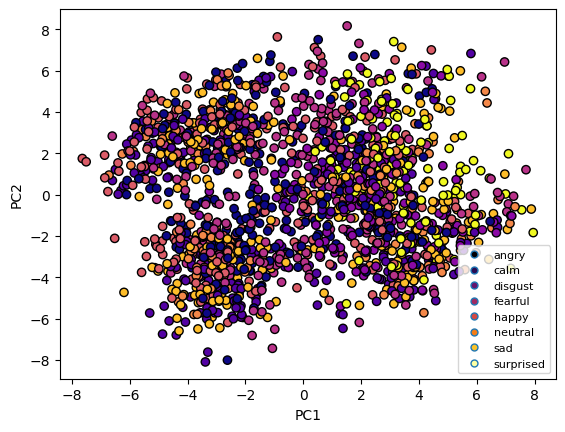

In [43]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

labels = y_train
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('inferno', len(unique_labels))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=LabelEncoder().fit_transform(y_train), cmap='plasma', edgecolors='k', alpha=1)

# legenda con la corrispondenza tra colori e unique_labels
handles = []
for i, ulabel in enumerate(unique_labels):
    handle = plt.Line2D([], [], linestyle='none', marker='o', alpha=1.0, markersize=5, markerfacecolor=colors(i))
    handles.append(handle)
plt.legend(handles, unique_labels, fontsize= 8, loc = 'lower right')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

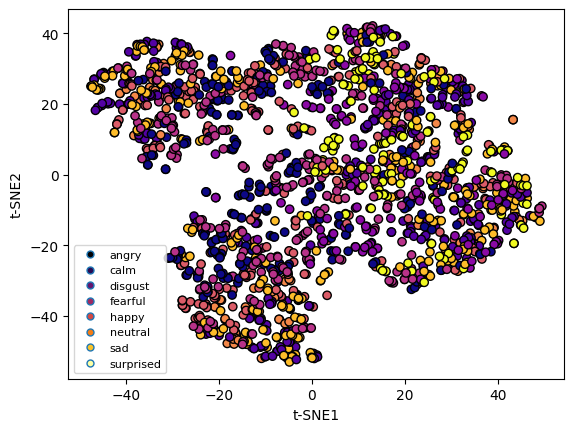

In [7]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=LabelEncoder().fit_transform(y_train), cmap='plasma', edgecolors='k', alpha=1)

# legenda con la corrispondenza tra colori e unique_labels
handles = []
for i, ulabel in enumerate(unique_labels):
    handle = plt.Line2D([], [], linestyle='none', marker='o', alpha=1.0, markersize=5, markerfacecolor=colors(i))
    handles.append(handle)
plt.legend(handles, unique_labels, fontsize = 8)

plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.show()

### SVM with default params

In [158]:
svc5 = SVC()
svc5.fit(X_train, y_train)

y_pred = svc5.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.47596153846153844
F1-score [0.6367713  0.56701031 0.5        0.41610738 0.42926829 0.38383838
 0.29378531 0.51546392]
              precision    recall  f1-score   support

       angry       0.56      0.74      0.64        96
        calm       0.56      0.57      0.57        96
     disgust       0.46      0.54      0.50        48
     fearful       0.58      0.32      0.42        96
       happy       0.40      0.46      0.43        96
     neutral       0.37      0.40      0.38        48
         sad       0.32      0.27      0.29        96
   surprised       0.51      0.52      0.52        48

    accuracy                           0.48       624
   macro avg       0.47      0.48      0.47       624
weighted avg       0.48      0.48      0.47       624



In [163]:
params = svc5.get_params()
print(params)
print(svc5.gamma)

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
scale


### SVM with parameter tuning

#### First model

In [66]:
'''
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 50, 100],
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5, 6, 7, 10],
    'gamma' : [0, .01, .1, 1, 5, 10, 100]
}
grid = RandomizedSearchCV(
    SVC(),
    param_distributions = param_grid,
    cv=RepeatedStratifiedKFold(random_state=42),
    n_jobs=-1,
    n_iter=200, 
)
grid.fit(X_train, y_train)

clf = grid.best_estimator_ '''

In [7]:
from tqdm import tqdm
param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [2, 3, 4, 5],
    'gamma' : [0, .1, 1, 10, 100],
}
 
clf = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=42),
                         n_iter=10, verbose=10, n_jobs=-1)

for i in tqdm(range(10)):
    clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.best_score_)


  0%|          | 0/10 [00:00<?, ?it/s]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 10%|█         | 1/10 [00:38<05:50, 38.99s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 20%|██        | 2/10 [01:25<05:45, 43.17s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 30%|███       | 3/10 [02:10<05:08, 44.06s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 40%|████      | 4/10 [02:57<04:32, 45.36s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 50%|█████     | 5/10 [04:00<04:18, 51.71s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 60%|██████    | 6/10 [04:45<03:17, 49.28s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 70%|███████   | 7/10 [05:46<02:39, 53.11s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 80%|████████  | 8/10 [06:38<01:45, 52.77s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 90%|█████████ | 9/10 [07:24<00:50, 50.90s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


100%|██████████| 10/10 [08:05<00:00, 48.59s/it]

SVC(C=0.1, gamma=1, kernel='poly')
0.5979422779325286


In [15]:
# PRIMO MODELLO HYPER TUNED: 

# print(clf.best_params_, clf.best_score_)
# {'kernel': 'poly', 'gamma': 100, 'degree': 3, 'C': 10} 0.5979422779325286
# Mean cross-validated score of the best_estimator (aka mean accuracy sul validation set) = 0.6

{'kernel': 'poly', 'gamma': 100, 'degree': 3, 'C': 10} 0.5979422779325286


In [176]:
# best SVC model so far 
svc = SVC(kernel= 'poly', gamma= 1, degree = 3, C = 0.1)
svc.fit(X_train, y_train)

SVC(C=0.1, gamma=1, kernel='poly')

In [177]:
# evaluation of the best model 
y_pred = svc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.4150641025641026
F1-score [0.53941909 0.53608247 0.45098039 0.38709677 0.34736842 0.31067961
 0.23776224 0.38202247]
              precision    recall  f1-score   support

       angry       0.45      0.68      0.54        96
        calm       0.53      0.54      0.54        96
     disgust       0.43      0.48      0.45        48
     fearful       0.40      0.38      0.39        96
       happy       0.35      0.34      0.35        96
     neutral       0.29      0.33      0.31        48
         sad       0.36      0.18      0.24        96
   surprised       0.41      0.35      0.38        48

    accuracy                           0.42       624
   macro avg       0.40      0.41      0.40       624
weighted avg       0.41      0.42      0.40       624



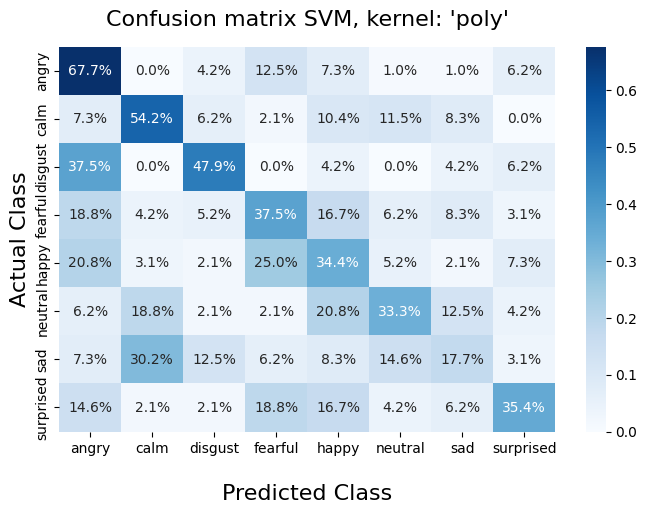

In [14]:
# evaluation of the first best model using a confusion matrix 

from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (8,5))
sns.heatmap(cf, annot=True, cmap="Blues", xticklabels=svc.classes_, yticklabels=svc.classes_ , fmt='.1%' )
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM, kernel: \'poly\'', fontsize = 16, pad = 15)
plt.show()

#### Second model

In [178]:
# secondo modello 

svc_secondo = SVC(C=0.1, gamma=1, kernel='poly')
svc_secondo.fit(X_train, y_train)
y_pred_secondo = svc_secondo.predict(X_test)

# evaluation 

print('Accuracy %s' % accuracy_score(y_test, y_pred_secondo))
print(classification_report(y_test, y_pred_secondo))

Accuracy 0.4150641025641026
              precision    recall  f1-score   support

       angry       0.45      0.68      0.54        96
        calm       0.53      0.54      0.54        96
     disgust       0.43      0.48      0.45        48
     fearful       0.40      0.38      0.39        96
       happy       0.35      0.34      0.35        96
     neutral       0.29      0.33      0.31        48
         sad       0.36      0.18      0.24        96
   surprised       0.41      0.35      0.38        48

    accuracy                           0.42       624
   macro avg       0.40      0.41      0.40       624
weighted avg       0.41      0.42      0.40       624



#### Third model

In [111]:
# terzo tentativo 

param_grid = {
    'C' : [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048, 8192, 32768],
    'kernel' : ['rbf'],
    'gamma' : [3.0517578125e-05, 0.0001220703125, 0.00048828125, 0.001953125, 0.0078125, 0.03125, 0.125, 0.5, 2, 8],
}
 
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)


clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(clf.best_score_)

SVC(C=32, gamma=0.001953125)
0.4468724852986692


In [179]:
svc_terzo = SVC(C=32, gamma=0.001953125, probability = True)
svc_terzo.fit(X_train, y_train)
y_pred_terzo = svc_terzo.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred_terzo))

Accuracy 0.46794871794871795


In [35]:
print(classification_report(y_test, y_pred_terzo))

              precision    recall  f1-score   support

       angry       0.51      0.81      0.63        96
        calm       0.51      0.56      0.54        96
     disgust       0.43      0.54      0.48        48
     fearful       0.57      0.30      0.39        96
       happy       0.44      0.36      0.40        96
     neutral       0.41      0.46      0.43        48
         sad       0.33      0.24      0.28        96
   surprised       0.48      0.52      0.50        48

    accuracy                           0.47       624
   macro avg       0.46      0.48      0.46       624
weighted avg       0.47      0.47      0.45       624



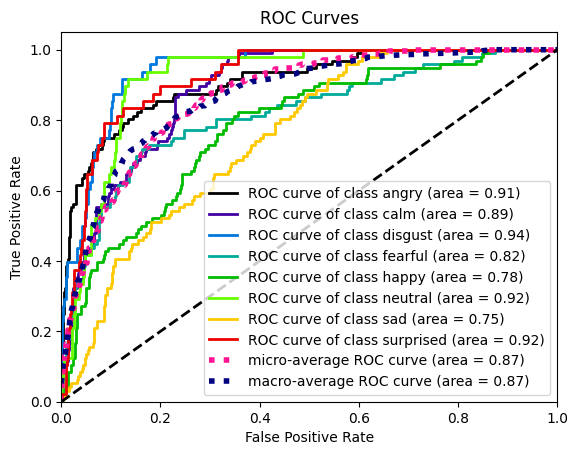

In [36]:
y_proba = svc_terzo.predict_proba(X_test)
plot_roc(y_test, y_proba)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

cf_terza = confusion_matrix(y_test, y_pred_terzo)
plt.figure(figsize = (8,5))
sns.heatmap(cf_terza, annot=True, cmap="Blues", xticklabels=svc_terzo.classes_, yticklabels=svc_terzo.classes_ , fmt='.1%' )
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM - kernel: \'rbf\'', fontsize = 16, pad = 15)
plt.show()

In [120]:
cv_df = pd.DataFrame(clf.cv_results_)

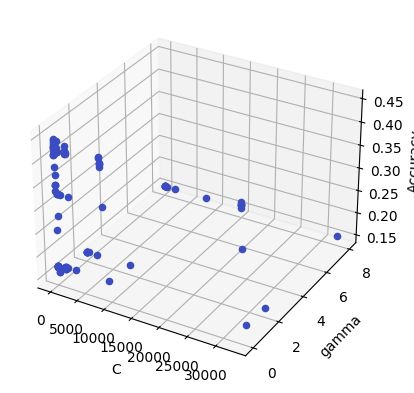

C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\3280577361.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(gammas))
C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\3280577361.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(Cs))


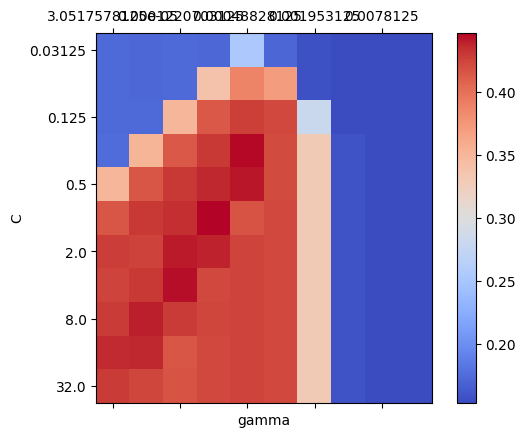

C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\3280577361.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(gammas))
C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\3280577361.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(Cs))


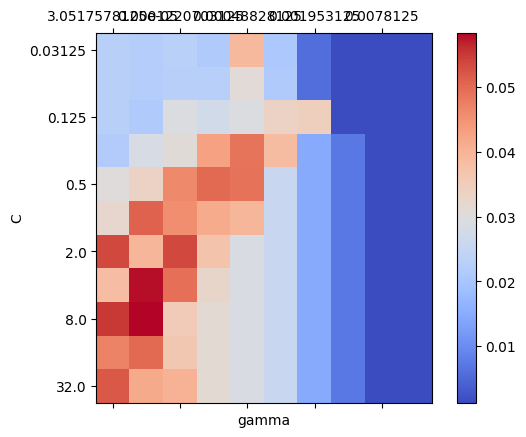

In [124]:
from mpl_toolkits.mplot3d import Axes3D

# estrai i risultati della grid search
results = clf.cv_results_
params = results['params']
mean_test_score = results['mean_test_score']
std_test_score = results['std_test_score']

# crea una lista di valori di C e gamma unici
Cs = np.unique([d['C'] for d in params])
gammas = np.unique([d['gamma'] for d in params])

# grafico della relazione tra C e gamma
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, C in enumerate(Cs):
    for j, gamma in enumerate(gammas):
        score = mean_test_score[i * len(gammas) + j]
        ax.scatter(C, gamma, score, c=score, cmap='coolwarm')
ax.set_xlabel('C')
ax.set_ylabel('gamma')
ax.set_zlabel('Accuracy')
plt.show()


In [44]:
support_vectors_pca = pca.transform(svc_terzo.support_vectors_) #[:10]

C:\Users\Valeria\AppData\Local\Temp\ipykernel_9536\12033259.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('inferno', len(unique_labels))


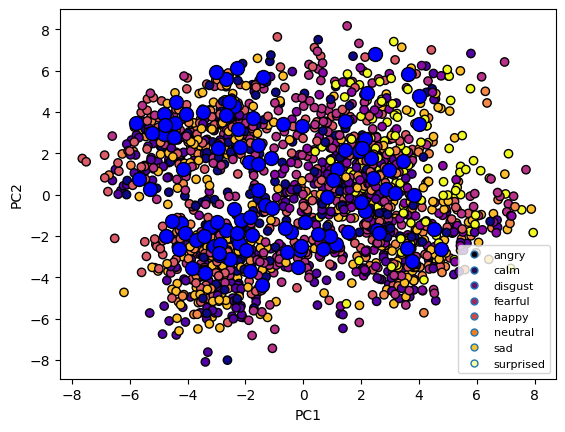

In [45]:
labels = y_train
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('inferno', len(unique_labels))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=LabelEncoder().fit_transform(y_train), cmap='plasma', edgecolors='k', alpha=1)

# legenda con la corrispondenza tra colori e unique_labels
handles = []
for i, ulabel in enumerate(unique_labels):
    handle = plt.Line2D([], [], linestyle='none', marker='o', alpha=1.0, markersize=5, markerfacecolor=colors(i))
    handles.append(handle)
plt.legend(handles, unique_labels, fontsize= 8, loc = 'lower right')

plt.xlabel('PC1')
plt.ylabel('PC2')
#aggiungo al plot anche i support vectors
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='b', edgecolors='k')
plt.show()

In [ ]:
pip install mlxtend


### SVM on the reduced feature space - just to have a look at the decision boundary

Accuracy: 0.2564102564102564


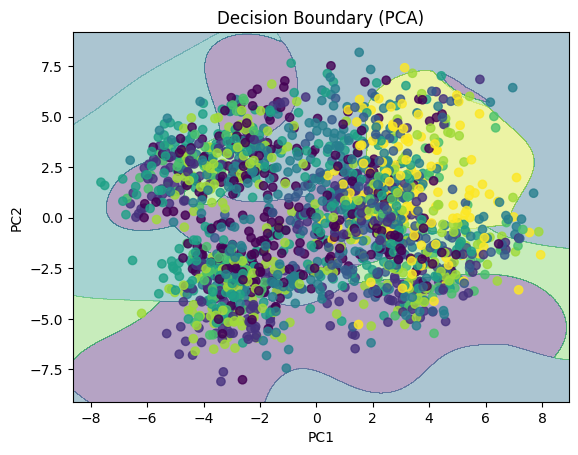

In [106]:
# train an SVM model on the reduced feature space
y_train_encoded = LabelEncoder().fit_transform(y_train)
clf_pca = SVC(C=0.5, gamma=0.125)
clf_pca.fit(X_pca, y_train_encoded)

y_test_encoded = LabelEncoder().fit_transform(y_test)
X_test_pca = pca.transform(X_test)
accuracy = clf_pca.score(X_test_pca, y_test_encoded)
print("Accuracy:", accuracy)



# create a fine-grained grid of points spanning the reduced feature space
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# make predictions for the grid of points using the separate SVM model
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# plot the decision boundary on top of the scatter plot of the reduced feature space
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_encoded, alpha=0.8)

# add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision Boundary (PCA)')

plt.show() 

In [105]:
param_grid = {
    'C' : [0.03125, 0.125, 0.5, 2, 8, 32, 128, 512, 2048, 8192, 32768],
    'kernel' : ['rbf'],
    'gamma' : [3.0517578125e-05, 0.0001220703125, 0.00048828125, 0.001953125, 0.0078125, 0.03125, 0.125, 0.5, 2, 8],
}
 
clf = GridSearchCV(SVC(), param_grid, n_jobs=-1)


clf.fit(X_pca, y_train_encoded)

print(clf.best_estimator_)
print(clf.best_score_)

SVC(C=0.5, gamma=0.125)
0.2623553079541937


### SVM including also categorical variables - one hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df_train_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'C:\Users\Valeria\Documents\Università\DS\DM2\LAB\RavdessAudioOnlyFeatures_TEST.csv')

df_train_cat = training_pulito(df_train_csv)[1].drop('filename', axis = 1)  #droppo 'filename' perchè inutile, altrimenti mi esplode il numero delle colonne coded
df_test_cat = test_pulito(df_test_csv)[1].drop('filename', axis=1)

cat_features =[
 'sex']

X_train_cat = df_train_cat[cat_features]
X_test_cat = df_test_cat[cat_features]

# trasformo sia per train che per test
le = LabelEncoder()
for feature in cat_features:
    X_train_cat[feature] = le.fit_transform(X_train_cat[feature])
    X_test_cat[feature] = le.transform(X_test_cat[feature])



X_train_tmp = pd.concat([df_train_cat.drop(cat_features, axis=1), pd.DataFrame(X_train_cat)], axis=1)
X_train_enc = X_train_tmp.drop(['emotion','vocal_channel','modality',  
 'emotional_intensity',
 'statement',
 'repetition'], axis = 1).values
X_test_tmp = pd.concat([df_test_cat.drop(cat_features, axis=1), pd.DataFrame(X_test_cat)], axis=1)
X_test_enc = X_test_tmp.drop(['emotion','vocal_channel', 'modality',  
 'emotional_intensity',
 'statement',
 'repetition'], axis = 1).values

In [74]:
scaler = StandardScaler()
scaler.fit(X_train_enc)
X_train_enc_norm = scaler.transform(X_train_enc)
X_test_enc_norm = scaler.transform(X_test_enc)

y_train = training_pulito(df_train_csv)[1]['emotion']
y_test = test_pulito(df_test_csv)[1]['emotion']


c:\Users\Valeria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


In [75]:
%%timeit

svc_cat = SVC(kernel = 'rbf')
svc_cat.fit(X_train_enc_norm, y_train)

y_pred = svc_cat.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.49038461538461536
F1-score [0.62608696 0.5520362  0.52       0.43356643 0.5        0.3255814
 0.32941176 0.48888889]
              precision    recall  f1-score   support

       angry       0.54      0.75      0.63        96
        calm       0.49      0.64      0.55        96
     disgust       0.50      0.54      0.52        48
     fearful       0.66      0.32      0.43        96
       happy       0.46      0.54      0.50        96
     neutral       0.37      0.29      0.33        48
         sad       0.38      0.29      0.33        96
   surprised       0.52      0.46      0.49        48

    accuracy                           0.49       624
   macro avg       0.49      0.48      0.47       624
weighted avg       0.50      0.49      0.48       624

Accuracy 0.49038461538461536
F1-score [0.62608696 0.5520362  0.52       0.43356643 0.5        0.3255814
 0.32941176 0.48888889]
              precision    recall  f1-score   support

       angry       0.54      0.75     

In [ ]:
# bar plot, x = emotion 
# per ogni emozione voglio vedere vocal_channel o emotion_intensity

In [131]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

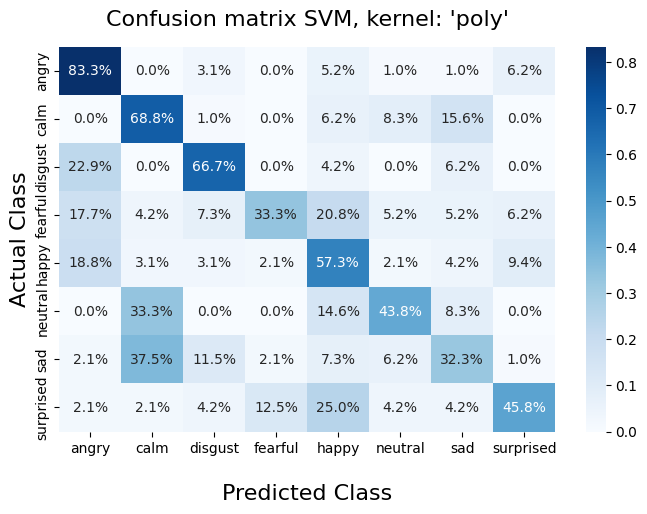

In [133]:
cf = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize = (8,5))
sns.heatmap(cf, annot=True, cmap="Blues", xticklabels=svc_cat.classes_, yticklabels=svc_cat.classes_ , fmt='.1%' )
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM, kernel: \'poly\'', fontsize = 16, pad = 15)
plt.show()

In [125]:
# provo a fare hyper parameters tuning del modello allenato sul dataset che contiene anche gli attributi categorici 
from tqdm import tqdm
param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'kernel' : ['poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma' : [0, .1, 1, 10, 100]
}
 
clf = RandomizedSearchCV(SVC(), param_grid, cv=RepeatedStratifiedKFold(random_state=42),
                         n_iter=10, verbose=10, n_jobs=-1)

for i in tqdm(range(10)):
    clf.fit(X_train_enc_norm, y_train)

clf.best_estimator_

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 10%|█         | 1/10 [01:13<10:57, 73.00s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 20%|██        | 2/10 [01:44<06:26, 48.36s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 30%|███       | 3/10 [02:21<05:04, 43.51s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 40%|████      | 4/10 [03:00<04:09, 41.55s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 50%|█████     | 5/10 [03:37<03:20, 40.09s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 60%|██████    | 6/10 [04:20<02:43, 40.79s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 70%|███████   | 7/10 [05:02<02:04, 41.46s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 80%|████████  | 8/10 [05:39<01:19, 39.94s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


 90%|█████████ | 9/10 [06:14<00:38, 38.34s/it]

Fitting 50 folds for each of 10 candidates, totalling 500 fits


100%|██████████| 10/10 [07:05<00:00, 42.52s/it]


SVC(C=100, gamma=0.1, kernel='poly')

In [34]:
svc_cat.coef_.shape


# The shape is [n_class * (n_class-1) / 2, n_features] but why?
# This is because if you have more than 2 classes i.e. 
# if you have a problem that is not binary then the multiclass support of the function is handled according to an one-vs-one scheme.

# Assume we have 3 classes 1, 2, 3. 
# Here, in the clf.coef_, each row corresponds to the above cases 1vs2, 1vs3 and 2vs3, respectively. 
# So, first row i.e. [-0.5, -0.5] gives you the coefficient of the first and second feature/variable for the case of 1vs2 classification fitting.

(28, 62)

In [ ]:
names = list(X_test_tmp.columns)
names.remove('emotion')

### Feature permutation importance 

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


f_importances(svc_terzo.coef_, names)

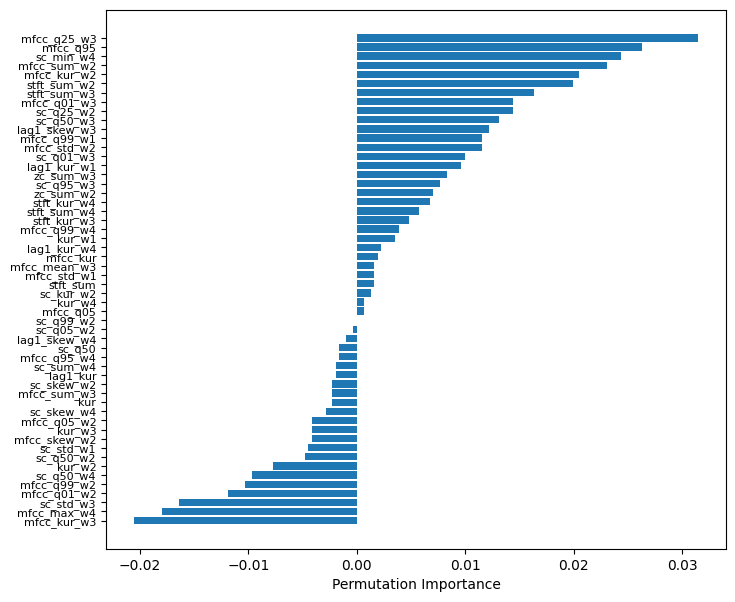

In [264]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(svc_terzo, X_test, y_test)
features = np.array(df_train.columns)


sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 7))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.yticks(fontsize=8)
plt.show()


Try to see how the model's performance changes by removing the features that have a permutation importance between -0.01 and 0.01

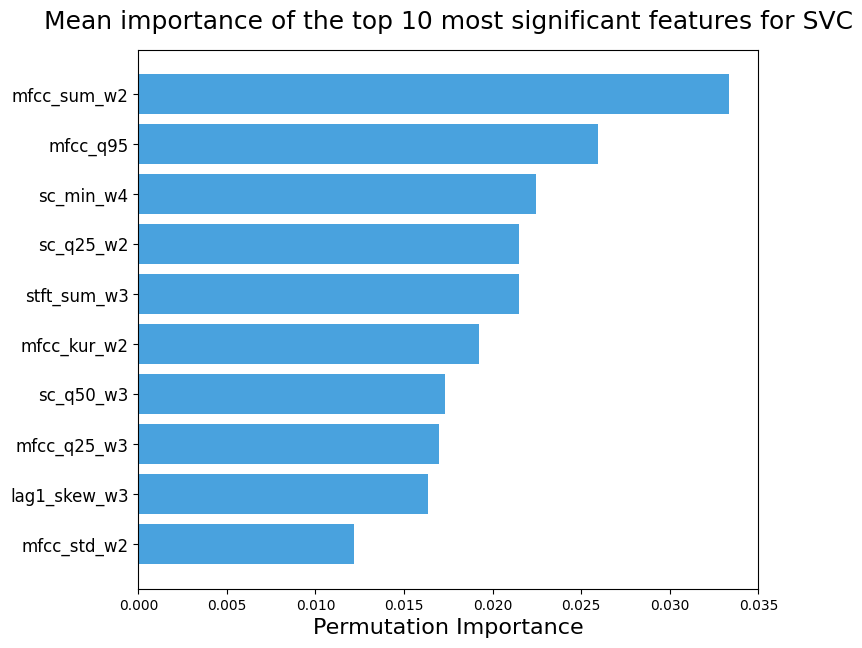

In [269]:
perm_importance = permutation_importance(svc_terzo, X_test, y_test)
features = np.array(df_train.columns)

sorted_idx_bis = perm_importance.importances_mean.argsort()[-10:]
plt.figure(figsize=(8, 7))
plt.barh(features[sorted_idx_bis], perm_importance.importances_mean[sorted_idx_bis], color='#49a2de')
plt.xlabel("Permutation Importance", fontsize= 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.title("Mean importance of the top 10 most significant features for SVC", fontsize= 18, pad = 15)
plt.show()

In [67]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# creo validation set, X_val e y_val 
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train_enc_norm, y_train, stratify = y_train, test_size = 0.3, random_state = 42)
'''r = permutation_importance(svc, X_val, y_val,
                           n_repeats=30,
                           random_state=0)
# creo validation set, X_val e y_val  '''


'r = permutation_importance(svc, X_val, y_val,\n                           n_repeats=30,\n                           random_state=0)\n# creo validation set, X_val e y_val  '

In [102]:
svc_val = SVC()
svc_val.fit(X_train_train, y_train_train)

SVC()

In [103]:
r = permutation_importance(svc_val, X_val, y_val,
                           n_repeats=30,
                           random_state=0)

In [104]:
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:   # l'if seleziona solo le feature le cui importanze sono maggiori di due volte la deviazione standard dell'importanza media
         print(f"{names[i]}  "
               f"{r.importances_mean[i]:.3f}"
               f" +/- {r.importances_std[i]:.3f}")
         
# selezionare solo le feature che hanno un'importanza media maggiore di due volte la deviazione standard 
# significa che le feature selezionate hanno un'importanza più stabile rispetto a quelle con deviazione standard più elevata.
# la feature "vocal_channel" ha l'importanza media più elevata tra tutte le feature considerate, con un valore di 0.170 +/- 0.012.
# a deviazione standard dell'importanza media, che indica la variabilità dell'importanza della feature in diverse ripetizioni della permutazione.
# In questo caso, la deviazione standard è relativamente bassa rispetto all'importanza media, quindi l'importanza della feature "vocal_channel" è piuttosto stabile e affidabile.

emotional_intensity  0.033 +/- 0.009
vocal_channel  0.017 +/- 0.006


Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled [1]. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

Warning Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.
The permutation_importance function calculates the feature importance of estimators for a given dataset. The n_repeats parameter sets the number of times a feature is randomly shuffled and returns a sample of feature importances.

### Recap of the final best model

In [ ]:
# Modello finale che andrà nel progetto: 

In [168]:
svc_10 = SVC(C = 32, class_weight = 'balanced', gamma = 0.001953125, probability = True)
svc_10.fit(X_train, y_train)
y_pred_10 = svc_10.predict(X_test)
print(accuracy_score(y_test, y_pred_10))

0.4823717948717949


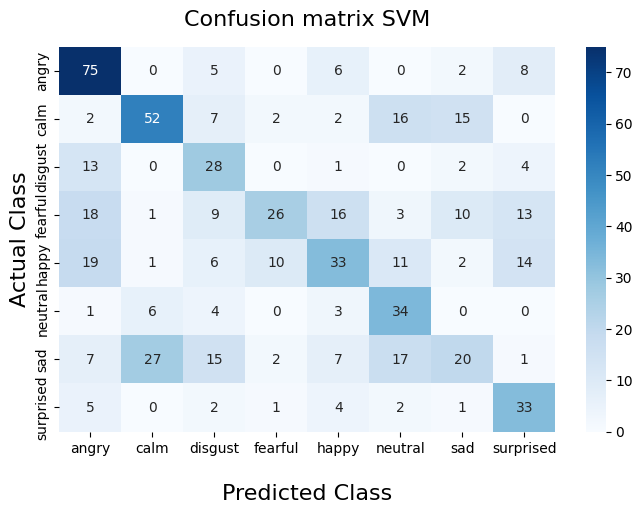

In [259]:
from sklearn.metrics import confusion_matrix

cf_10 = confusion_matrix(y_test, y_pred_10, normalize='true')
plt.figure(figsize = (8,5))
sns.heatmap(cf_10, annot=True, cmap="Blues", xticklabels=svc_10.classes_, yticklabels=svc_10.classes_ , fmt='.1%')
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix SVM', fontsize = 16, pad = 15)
plt.show()


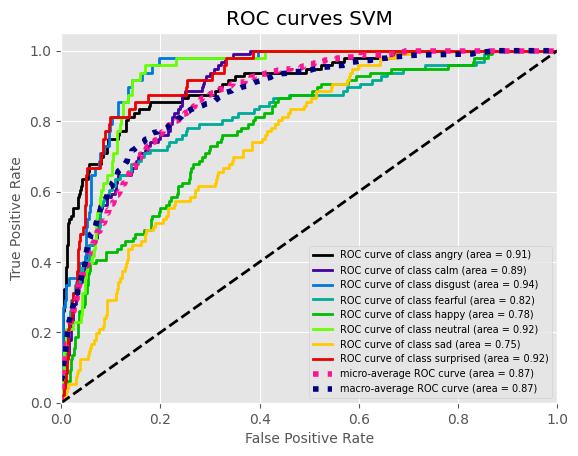

In [170]:
y_proba_10 = svc_10.predict_proba(X_test)
plot_roc(y_test, y_proba_10)
plt.legend(prop={'size':7})
plt.style.use('ggplot')
plt.title('ROC curves SVM')
plt.show()
# QUESTA 

In [178]:
print(svc_10.score(X_train, y_train))
print('Accuracy %s' % accuracy_score(y_test, y_pred_10))

0.745414118954975
Accuracy 0.4823717948717949


In [253]:
print(classification_report(y_test, y_pred_10))

              precision    recall  f1-score   support

       angry       0.54      0.78      0.64        96
        calm       0.60      0.54      0.57        96
     disgust       0.37      0.58      0.45        48
     fearful       0.63      0.27      0.38        96
       happy       0.46      0.34      0.39        96
     neutral       0.41      0.71      0.52        48
         sad       0.38      0.21      0.27        96
   surprised       0.45      0.69      0.55        48

    accuracy                           0.48       624
   macro avg       0.48      0.52      0.47       624
weighted avg       0.50      0.48      0.46       624



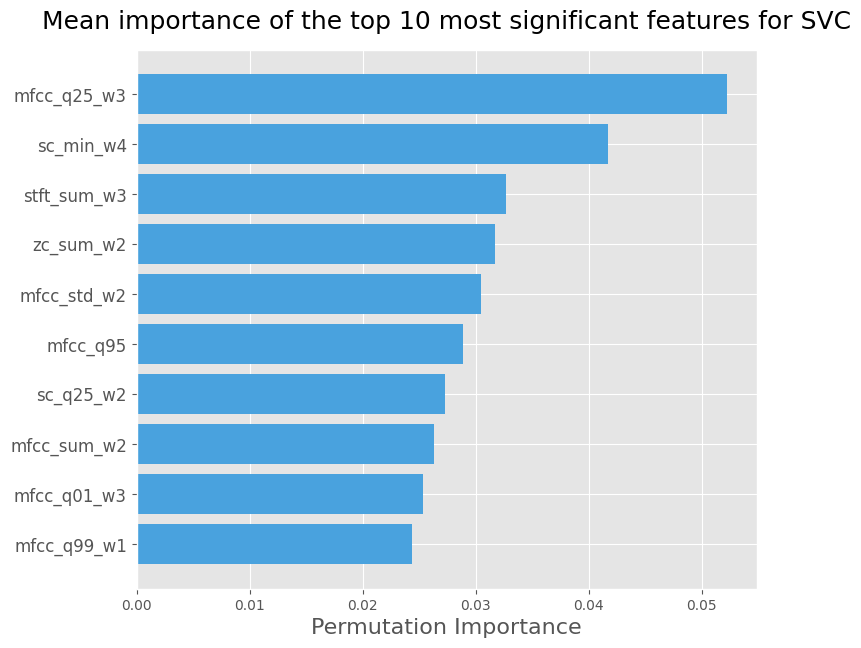

In [174]:
from sklearn.inspection import permutation_importance
perm_importance_10 = permutation_importance(svc_10, X_test, y_test)
features = np.array(df_train.columns)

sorted_idx_bis = perm_importance_10.importances_mean.argsort()[-10:]
plt.figure(figsize=(8, 7))
plt.barh(features[sorted_idx_bis], perm_importance_10.importances_mean[sorted_idx_bis], color='#49a2de')
plt.xlabel("Permutation Importance", fontsize= 16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=10)
plt.title("Mean importance of the top 10 most significant features for SVC", fontsize= 18, pad = 15)
plt.style.use('ggplot')
plt.show()

## RANDOM FOREST

In [7]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:

df_train_csv = pd.read_csv(r'RavdessAudioOnlyFeatures_TRAIN.csv')
df_test_csv = pd.read_csv(r'RavdessAudioOnlyFeatures_TEST.csv')

df_train_cat = training_pulito(df_train_csv)[1].drop('filename', axis = 1)  #droppo 'filename' perchè inutile
df_test_cat = test_pulito(df_test_csv)[1].drop('filename', axis=1)

cat_features =['sex','emotion','vocal_channel','modality',  'emotional_intensity', 'statement', 'repetition']

X_train_cat = df_train_cat[cat_features]
X_test_cat = df_test_cat[cat_features]

# trasformo sia per train che per test
le = LabelEncoder()
for feature in cat_features:
    X_train_cat[feature] = le.fit_transform(X_train_cat[feature])
    X_test_cat[feature] = le.transform(X_test_cat[feature])


X_train_tmp = pd.concat([df_train_cat.drop(cat_features, axis=1), pd.DataFrame(X_train_cat)], axis=1)
X_train_enc = X_train_tmp.drop('emotion', axis=1).values
X_test_tmp = pd.concat([df_test_cat.drop(cat_features, axis=1), pd.DataFrame(X_test_cat)], axis=1)
X_test_enc = X_test_tmp.drop('emotion', axis=1).values

scaler = StandardScaler()
scaler.fit(X_train_enc)
X_train_enc_norm = scaler.transform(X_train_enc)
X_test_enc_norm = scaler.transform(X_test_enc)

y_train = training_pulito(df_train_csv)[1]['emotion']
y_test = test_pulito(df_test_csv)[1]['emotion']

### Random forest with default params

In [62]:
# valuto inizialmente l'ensemble con i parametri di default 
rfcbis = RandomForestClassifier(max_depth = 8)
rfcbis.fit(X_train_enc_norm, y_train)

y_pred_rfc = rfcbis.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred_rfc))
print(classification_report(y_test, y_pred_rfc))

Accuracy 0.46474358974358976
              precision    recall  f1-score   support

       angry       0.48      0.82      0.61        96
        calm       0.55      0.68      0.61        96
     disgust       0.48      0.33      0.40        48
     fearful       0.55      0.19      0.28        96
       happy       0.40      0.40      0.40        96
     neutral       0.48      0.23      0.31        48
         sad       0.37      0.35      0.36        96
   surprised       0.45      0.60      0.51        48

    accuracy                           0.46       624
   macro avg       0.47      0.45      0.43       624
weighted avg       0.47      0.46      0.44       624



In [63]:
train_score = rfcbis.score(X_train_enc_norm, y_train)

In [64]:
print(train_score)

0.9471928849360756


### Random Forest with optimized params

In [20]:
# Playing a bit with parameters
rfc2 = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=32, min_samples_split=6, 
                             min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features='log2', random_state=0)   #max_features = 'auto' means sqrt(n)
rfc2.fit(X_train, y_train)

y_pred_2 = rfc2.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_2))
print('F1-score %s' % f1_score(y_test, y_pred_2, average=None))
print(classification_report(y_test, y_pred_2))

Accuracy 0.4358974358974359
F1-score [0.55849057 0.57971014 0.37974684 0.29007634 0.35978836 0.21212121
 0.34196891 0.50847458]
              precision    recall  f1-score   support

       angry       0.44      0.77      0.56        96
        calm       0.54      0.62      0.58        96
     disgust       0.48      0.31      0.38        48
     fearful       0.54      0.20      0.29        96
       happy       0.37      0.35      0.36        96
     neutral       0.39      0.15      0.21        48
         sad       0.34      0.34      0.34        96
   surprised       0.43      0.62      0.51        48

    accuracy                           0.44       624
   macro avg       0.44      0.42      0.40       624
weighted avg       0.44      0.44      0.41       624



In [29]:
# Hyper parameters tuning - I keep number of estimators to 100, as suggested. 
# first attempt
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
             }

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_list, cv=5)
grid_search.fit(X_train_enc_norm, y_train)
clf = grid_search.best_estimator_
print(grid_search.best_score_)

y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

# QUESTO!!!!! mean accuracy on validation set : 0.44246

0.4424651810584958
Accuracy 0.47596153846153844
F1-score [0.59770115 0.62100457 0.43373494 0.33082707 0.4        0.35294118
 0.3575419  0.50909091]
              precision    recall  f1-score   support

       angry       0.47      0.81      0.60        96
        calm       0.55      0.71      0.62        96
     disgust       0.51      0.38      0.43        48
     fearful       0.59      0.23      0.33        96
       happy       0.39      0.41      0.40        96
     neutral       0.60      0.25      0.35        48
         sad       0.39      0.33      0.36        96
   surprised       0.45      0.58      0.51        48

    accuracy                           0.48       624
   macro avg       0.50      0.46      0.45       624
weighted avg       0.49      0.48      0.45       624



In [32]:
# second attempt
param_list = {'max_depth': [None] + list(np.arange(2, 20)),
              'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
              'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
             }

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train_enc_norm, y_train)
clf = random_search.best_estimator_
print(random_search.best_score_, random_search.best_params_)

y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


0.4391287527081399 {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 16}
Accuracy 0.4583333333333333
F1-score [0.59919028 0.58653846 0.40425532 0.28169014 0.41052632 0.41558442
 0.35675676 0.45714286]
              precision    recall  f1-score   support

       angry       0.49      0.77      0.60        96
        calm       0.54      0.64      0.59        96
     disgust       0.41      0.40      0.40        48
     fearful       0.43      0.21      0.28        96
       happy       0.41      0.41      0.41        96
     neutral       0.55      0.33      0.42        48
         sad       0.37      0.34      0.36        96
   surprised       0.42      0.50      0.46        48

    accuracy                           0.46       624
   macro avg       0.46      0.45      0.44       624
weighted avg       0.45      0.46      0.44       624



In [30]:
# third attempt

from scipy.stats import uniform, randint, loguniform

param_list = {'max_depth': randint(2, 200),
              'min_samples_split': loguniform(1e-2, 1e0),
              'min_samples_leaf': [0.001, 0.2, 0.8, 1, 2, 6, 10, 30],
              'ccp_alpha' : [0.001,0.0025, 0.03, 0.04, 0.1, 0.5],
              'class_weight' : ['balanced', 'balanced_subsample'],
              'max_features' : ['sqrt', 'log2'],
              'criterion' : ['entropy', 'gini']
             }

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train_enc_norm, y_train)
clf = random_search.best_estimator_
print(random_search.best_score_, random_search.best_params_)


y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(random_search.best_params_, random_search.best_score_)

Accuracy 0.42467948717948717
F1-score [0.60425532 0.54450262 0.39215686 0.19298246 0.35087719 0.42201835
 0.17322835 0.5       ]
              precision    recall  f1-score   support

       angry       0.51      0.74      0.60        96
        calm       0.55      0.54      0.54        96
     disgust       0.29      0.62      0.39        48
     fearful       0.61      0.11      0.19        96
       happy       0.40      0.31      0.35        96
     neutral       0.38      0.48      0.42        48
         sad       0.35      0.11      0.17        96
   surprised       0.37      0.77      0.50        48

    accuracy                           0.42       624
   macro avg       0.43      0.46      0.40       624
weighted avg       0.45      0.42      0.39       624

{'ccp_alpha': 0.0025, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 55, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.03133193047356879} 0.3957706592386258


In [33]:
# fourth attempt

param_list = {'max_depth': randint(2, 200), #def None
              'min_samples_split': [2, 3, 4, 5, 6, 7], #def 2
              'min_samples_leaf': [0.001, 0.2, 0.8, 2, 6, 10, 30],  #def 1
              'class_weight' : [None, 'balanced', 'balanced_subsample'], #def None
              'max_features' : ['sqrt', 'log2'], #def sqrt
              'criterion' : ['entropy', 'gini'] #def gini
             }

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train_enc_norm, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(random_search.best_params_, random_search.best_score_)



Accuracy 0.4855769230769231
F1-score [0.6255144  0.60194175 0.5106383  0.34532374 0.4137931  0.32911392
 0.35632184 0.56363636]
              precision    recall  f1-score   support

       angry       0.52      0.79      0.63        96
        calm       0.56      0.65      0.60        96
     disgust       0.52      0.50      0.51        48
     fearful       0.56      0.25      0.35        96
       happy       0.39      0.44      0.41        96
     neutral       0.42      0.27      0.33        48
         sad       0.40      0.32      0.36        96
   surprised       0.50      0.65      0.56        48

    accuracy                           0.49       624
   macro avg       0.48      0.48      0.47       624
weighted avg       0.48      0.49      0.47       624

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 46, 'max_features': 'log2', 'min_samples_leaf': 0.001, 'min_samples_split': 5} 0.4419204580625193


In [84]:
# fifth attempt 
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_list = {'max_depth': [8], #def None
              'min_samples_split': [2, 3, 4, 5, 6, 7], #def 2
              'min_samples_leaf': [2, 6, 10,15, 16, 17, 18, 19, 30, 60],  #def 1
              'class_weight' : [None, 'balanced', 'balanced_subsample'], #def None
              'max_features' : [6], #def sqrt
              'criterion' : ['entropy'] #def gini
             }

random_search = RandomizedSearchCV(RandomForestClassifier(n_estimators = 300), param_distributions=param_list, n_iter=20, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
random_search.fit(X_train_enc_norm, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('mean validation score and best hyper params', random_search.best_params_, random_search.best_score_)


# QUESTO!! Mean accuracy validation set : 0.4458

Accuracy 0.4807692307692308
              precision    recall  f1-score   support

       angry       0.53      0.73      0.62        96
        calm       0.60      0.64      0.62        96
     disgust       0.36      0.77      0.49        48
     fearful       0.80      0.17      0.28        96
       happy       0.49      0.38      0.42        96
     neutral       0.42      0.58      0.49        48
         sad       0.45      0.18      0.25        96
   surprised       0.39      0.73      0.51        48

    accuracy                           0.48       624
   macro avg       0.50      0.52      0.46       624
weighted avg       0.53      0.48      0.45       624

mean validation score and best hyper params {'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 6, 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced'} 0.5797709687403281


In [86]:
# performance sul training set 
print(clf.score(X_train_enc_norm, y_train)) # 

0.9544191217342969


In [134]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_list = {'max_depth': [ 5, 6, 7, 8, 9, 10, 12, 14], #default  None
              'min_samples_split': [2, 3, 4], #default  2
              'min_samples_leaf': [2, 3, 4, 5, 6, 10, 15],   
              'max_features' : [4, 5, 6, 7,  8, 9], 
              'max_leaf_nodes': [6, 7, 8, 9, 10, 15, 20, 25, 30, 40]
             }

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_list, n_iter=20, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
random_search.fit(X_train_enc_norm, y_train)
rfc3 = random_search.best_estimator_


y_pred3 = rfc3.predict(X_test_enc_norm)
# print(classification_report(y_test, y_pred))
print('mean validation accuracy and best hyper params',random_search.best_score_ ,random_search.best_params_)
print('accuracy training:', rfc3.score(X_train_enc_norm, y_train))
print('Accuracy test %s' % accuracy_score(y_test, y_pred3))




mean validation accuracy and best hyper params 0.4824899411946766 {'min_samples_split': 2, 'min_samples_leaf': 6, 'max_leaf_nodes': 30, 'max_features': 6, 'max_depth': 8}
accuracy training: 0.6948304613674263
Accuracy test 0.4326923076923077


In [121]:
from sklearn.metrics import f1_score

y_pred_train_rfc3 = prova.predict(X_train_enc_norm)
f1_score_train = f1_score(y_train, y_pred_train_rfc3, average = 'macro')

In [122]:
f1_score_train

0.6550242741946928

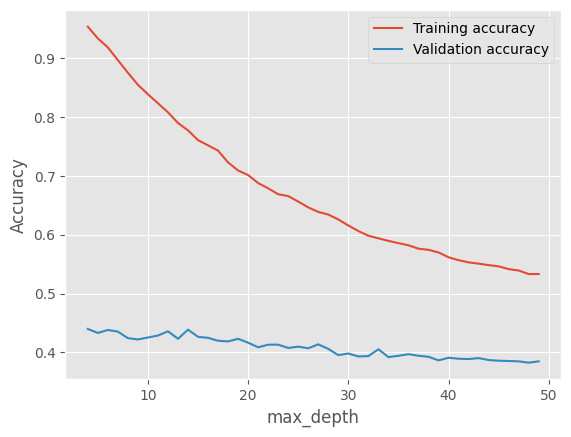

In [127]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
param_list = {'min_samples_leaf': list(range(4,50))}
grid = GridSearchCV(RandomForestClassifier(max_depth = 9, n_estimators = 100, min_samples_split = 3, min_samples_leaf = 5, random_state=22, max_features = 8),param_list, scoring='accuracy', return_train_score=True)
grid.fit(X_train_enc_norm, y_train)

train_scores = grid.cv_results_['mean_train_score']
val_scores = grid.cv_results_['mean_test_score']

min_samples_leaf_ranges = param_list['min_samples_leaf']

# plotta l'accuracy sul set di training e sul set di validazione in funzione del numero di stimatori
plt.plot(min_samples_leaf_ranges, train_scores, label='Training accuracy')
plt.plot(min_samples_leaf_ranges, val_scores, label='Validation accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.style.use('ggplot')
plt.legend()
plt.show()

In [67]:
#fine tuning around the best hyper params found in the FIFTH attempt
#{'class_weight': None, 'criterion': 'entropy', 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 5}

param_list = {'max_depth': list(range(6, 12)), #def None
              'min_samples_split': [3, 4, 5, 6, 7, 8], #def 2
              'min_samples_leaf': [0.001, 0.002, 0.01, 0.1],  #def 1
              'class_weight' : [None, 'balanced'],
              'max_features' : ['sqrt'], #def sqrt
              'criterion' : ['entropy'] #def gini
             }

random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_list, n_iter=20, cv=5)
random_search.fit(X_train_enc_norm, y_train)
clf = random_search.best_estimator_


y_pred = clf.predict(X_test_enc_norm)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(random_search.best_params_, random_search.best_score_)

Accuracy 0.4599358974358974
              precision    recall  f1-score   support

       angry       0.51      0.74      0.60        96
        calm       0.57      0.64      0.60        96
     disgust       0.36      0.73      0.48        48
     fearful       0.56      0.15      0.23        96
       happy       0.46      0.33      0.39        96
     neutral       0.45      0.56      0.50        48
         sad       0.38      0.15      0.21        96
   surprised       0.38      0.69      0.49        48

    accuracy                           0.46       624
   macro avg       0.46      0.50      0.44       624
weighted avg       0.47      0.46      0.43       624

{'min_samples_split': 6, 'min_samples_leaf': 0.001, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'entropy', 'class_weight': 'balanced'} 0.44078768183225014


In [36]:
# modello definitivo costruito con gli iper parametri del 5 tentativo
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight = None, criterion= 'entropy', max_depth= 72, max_features= 'sqrt', min_samples_leaf= 0.001, min_samples_split= 5, n_estimators = 100)
rfc.fit(X_train_enc_norm, y_train)
y_pred = rfc.predict(X_test_enc_norm)
train_score = rfc.score(X_train_enc_norm, y_train)

print('Score training set: ', train_score)
print('Mean score validation set: 0.4458')
print(classification_report(y_test, y_pred))

Score training set:  1.0
Mean score validation set: 0.4458
              precision    recall  f1-score   support

       angry       0.45      0.75      0.56        96
        calm       0.58      0.65      0.61        96
     disgust       0.54      0.46      0.49        48
     fearful       0.55      0.22      0.31        96
       happy       0.37      0.41      0.39        96
     neutral       0.41      0.31      0.35        48
         sad       0.38      0.28      0.32        96
   surprised       0.44      0.58      0.50        48

    accuracy                           0.46       624
   macro avg       0.46      0.46      0.44       624
weighted avg       0.47      0.46      0.44       624



In [ ]:
rfc2 = RandomForestClassifier(class_weight= None, criterion= 'entropy', max_depth= 54, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split= 7, n_estimators = 100)
rfc2.fit(X_train, y_train)
y_pred2 = rfc2.predict(X_test)

print(classification_report(y_test, y_pred2))

### Playing with ccp_alpha to control model complexity

In [10]:
# trying to improve the performances using ccp_alpha --> failed
# Define the hyperparameter grid to search
param_grid = {'ccp_alpha': [0.001, 0.01, 0.1, 1]}

# Use GridSearchCV to search for the best ccp_alpha value
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best ccp_alpha value and the corresponding test set accuracy
print("Best ccp_alpha value: {:.3f}".format(grid_search.best_params_['ccp_alpha']))
print("Accuracy on test set after pruning: {:.3f}".format(grid_search.best_estimator_.score(X_test, y_test)))

Best ccp_alpha value: 0.001
Accuracy on test set after pruning: 0.476


In [138]:
# feature importance
print("Feature importances:")
for feature, importance in zip(list(df_train_cat.columns), rfc3.feature_importances_):
    print("{}: {:.3f}".format(feature, importance))

# Select the most important features
# importance >= 0.02
important_features = [f for f, i in zip(list(df_train_cat.columns), rfc3.feature_importances_) if i >= 0.02]
print("Selected features: {}".format(important_features))

X_train_reduced = X_train_enc_norm[:, [i for i, feature in enumerate(list(df_train_cat.columns)) if feature in important_features]]
X_test_reduced = X_test_enc_norm[:, [i for i, feature in enumerate(list(df_train_cat.columns)) if feature in important_features]]

# importance >= 0.03
# important_features_bis = [f for f, i in zip(list(df_train_cat.columns), rfc3.feature_importances_) if i >= 0.03]
# print("Selected features: {}".format(important_features_bis))

#X_train_reduced = X_train_enc_norm[:, [i for i, feature in enumerate(list(df_train_cat.columns)) if feature in important_features]]
#X_test_reduced_ = X_test_enc_norm[:, [i for i, feature in enumerate(list(df_train_cat..columns)) if feature in important_features]]

Feature importances:
modality: 0.002
vocal_channel: 0.015
emotion: 0.012
emotional_intensity: 0.006
statement: 0.021
repetition: 0.058
actor: 0.019
sex: 0.007
kur: 0.014
lag1_kur: 0.009
mfcc_q05: 0.011
mfcc_q95: 0.006
mfcc_kur: 0.012
sc_q50: 0.004
sc_q75: 0.017
stft_sum: 0.009
kur_w1: 0.031
lag1_kur_w1: 0.078
mfcc_std_w1: 0.054
mfcc_q99_w1: 0.005
sc_std_w1: 0.007
kur_w2: 0.034
zc_sum_w2: 0.038
mfcc_sum_w2: 0.007
mfcc_std_w2: 0.012
mfcc_q01_w2: 0.023
mfcc_q05_w2: 0.006
mfcc_q99_w2: 0.006
mfcc_kur_w2: 0.018
mfcc_skew_w2: 0.024
sc_q05_w2: 0.027
sc_q25_w2: 0.023
sc_q50_w2: 0.017
sc_q99_w2: 0.027
sc_kur_w2: 0.024
sc_skew_w2: 0.054
stft_sum_w2: 0.015
kur_w3: 0.014
lag1_skew_w3: 0.014
zc_sum_w3: 0.009
mfcc_sum_w3: 0.009
mfcc_mean_w3: 0.016
mfcc_q01_w3: 0.012
mfcc_q25_w3: 0.022
mfcc_kur_w3: 0.010
sc_std_w3: 0.011
sc_min_w3: 0.016
sc_q01_w3: 0.007
sc_q50_w3: 0.014
sc_q95_w3: 0.005
stft_sum_w3: 0.008
stft_kur_w3: 0.008
kur_w4: 0.013
lag1_kur_w4: 0.008
lag1_skew_w4: 0.024
mfcc_max_w4: 0.009
mfcc_

In [140]:
X_train_reduced.shape

(1799, 16)

### Random Forest error and training time vs number of trees

In [ ]:
import time
# definisco il numero di alberi 
n_estimators_range = range(10, 300, 10)

# Train the model with different values of n_estimators - alleno sia i modelli sullo spazio ridotto che i modelli su spazio completo 
errors = []
errors_red = []
tempi = []
tempi_red = []

# errors_red_5 = []
for n_estimators in n_estimators_range:
    
    rfc = RandomForestClassifier(n_estimators = n_estimators, min_samples_split= 2, min_samples_leaf=  6, max_leaf_nodes =  30, max_features =  6, max_depth =  8 )
    rfc_red = RandomForestClassifier( n_estimators = n_estimators, min_samples_split= 2, min_samples_leaf=  6, max_leaf_nodes =  30, max_features =  6, max_depth =  8 )
    #rfc_red_5 = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=54, max_features='sqrt', min_samples_leaf=2, min_samples_split=7, n_estimators=n_estimators)

    ti_red = time.time()
    rfc_red.fit(X_train_reduced, y_train)
    tf_red = time.time()
    delta_tempi_red = tf_red - ti_red
    tempi_red.append(delta_tempi_red)

    ti = time.time()
    rfc.fit(X_train_enc_norm, y_train)
    tf = time.time()
    delta_tempo = tf - ti
    tempi.append(delta_tempo)
    
    
    y_pred = rfc.predict(X_test_enc_norm)
    accuracy = np.mean(y_pred == y_test)
    error = 1 - accuracy
    errors.append(error)
    
    
    y_pred_red = rfc_red.predict(X_test_reduced)
    accuracy_red = np.mean(y_pred_red == y_test)
    error_red = 1 - accuracy_red
    errors_red.append(error_red)



# Plot the error as a function of the number of trees
# plt.plot(n_estimators_range, errors, label = 'Trained on all features')
# plt.plot(n_estimators_range, errors_red, label = 'Trained on 15 most important features')
# plt.plot(n_estimators_range, errors_red_5, label = 'trained on 5 most important features') # non lo plotto non ha senso 

#plt.xlabel('Number of trees')
#plt.ylim(0.52, 0.64)
#plt.ylabel('Error (1-accuracy)')
#plt.title('Random Forest error vs number of trees')
#plt.style.use('ggplot')
#plt.legend(fontsize = 8)
#plt.show()

fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range, errors, label = 'Generalization error', color = "#F8766D")
ax2.plot(n_estimators_range, tempi, label = 'Training time', color = "#007fc4")


plt.xlabel('Number of trees')
ax1.set_ylim(0.55, 0.62)
ax1.set_ylabel('Error (1-accuracy)')
ax2.set_ylabel('Training time in seconds')
plt.title('Random Forest error and training time vs number of trees', pad=12)
plt.style.use('ggplot')
ax1.legend(fontsize = 8, loc='upper left')
ax2.legend(fontsize = 8, loc=(0.012, 0.86))
ax1.set_xlabel('Number of trees')

plt.show()


In [179]:
rf =  RandomForestClassifier( n_estimators = 10, min_samples_split= 2, min_samples_leaf=  6, max_leaf_nodes =  30, max_features =  6, max_depth =  8 )

In [180]:
rf.fit(X_train_reduced, y_train)
y_pred_pietro = rf.predict(X_test_reduced)

In [181]:
print('accuracy training:', rf.score(X_train_reduced, y_train))
print('Accuracy test %s' % accuracy_score(y_test, y_pred_pietro))

accuracy training: 0.5597554196775987
Accuracy test 0.3798076923076923


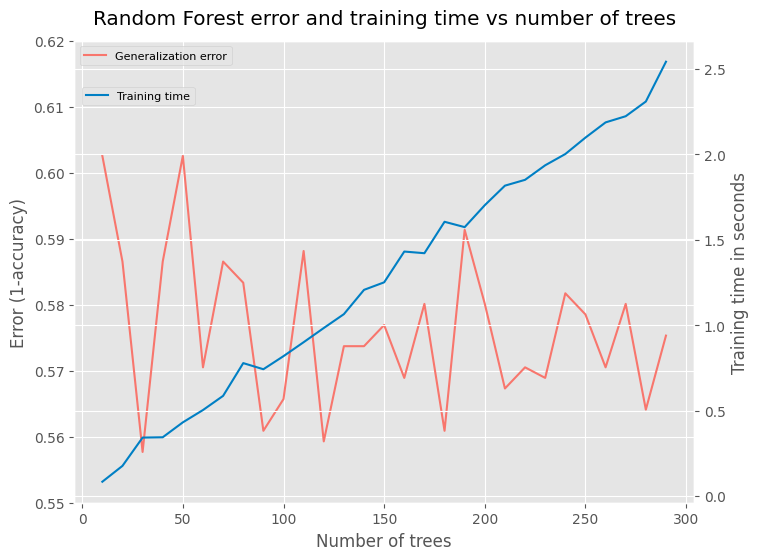

In [150]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range, errors, label = 'Generalization error', color = "#F8766D")
ax2.plot(n_estimators_range, tempi, label = 'Training time', color = "#007fc4")


plt.xlabel('Number of trees')
ax1.set_ylim(0.55, 0.62)
ax1.set_ylabel('Error (1-accuracy)')
ax2.set_ylabel('Training time in seconds')
plt.title('Random Forest error and training time vs number of trees', pad=12)
plt.style.use('ggplot')
ax1.legend(fontsize = 8, loc='upper left')
ax2.legend(fontsize = 8, loc=(0.012, 0.86))
ax1.set_xlabel('Number of trees')
fig1.set_size_inches(8, 6)
plt.show()


In [290]:
"""# voglio aggiungere al plot di prima un altro y axis (dual y axis plots), con il TRAINING TIME (fitting time)
# i due plot condivodno lo stesso x axis ovvero il numero di trees
# graficare tratteggiato rosso il fitting time dell'ensemble allenato sul training intero al variare di n_trees
# tratteggiato blu il fitting time dell'ensemble allenato sul training ridotto

import time
import matplotlib.pyplot as plt

# definisco il numero di alberi 
n_estimators_range = range(10, 201, 10)

# Train the model with different values of n_estimators - alleno sia i modelli sullo spazio ridotto che i modelli su spazio completo 
errors = []
errors_red = []
tempi = []
tempi_red = []
for n_estimators in n_estimators_range:
    rfc = RandomForestClassifier(n_estimators = n_estimators)
    rfc_red = RandomForestClassifier(n_estimators = n_estimators)

    ti_red = time.time()
    rfc_red.fit(X_train_reduced, y_train)
    tf_red = time.time()
    delta_tempi_red = tf_red - ti_red
    tempi_red.append(delta_tempi_red)

    ti = time.time()
    rfc.fit(X_train, y_train)
    tf = time.time()
    delta_tempo = tf - ti
    tempi.append(delta_tempo)
    
    y_pred = rfc.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    error = 1 - accuracy
    errors.append(error)
    
    
    y_pred_red = rfc_red.predict(X_test_reduced)
    accuracy_red = np.mean(y_pred_red == y_test)
    error_red = 1 - accuracy_red
    errors_red.append(error_red)


plt.plot(n_estimators_range, errors, label='Ensemble trained on 55 features')
plt.plot(n_estimators_range, errors_red, label='Ensemble trained on 15 most important features')
plt.xlabel('Number of trees')
plt.ylabel('Error (1-accuracy)')
plt.title('Random Forest error vs number of trees')
plt.ylim(0.52, 0.60)
plt.legend()
plt.style.use('ggplot')
plt.show()

"""

"# voglio aggiungere al plot di prima un altro y axis (dual y axis plots), con il TRAINING TIME (fitting time)\n# i due plot condivodno lo stesso x axis ovvero il numero di trees\n# graficare tratteggiato rosso il fitting time dell'ensemble allenato sul training intero al variare di n_trees\n# tratteggiato blu il fitting time dell'ensemble allenato sul training ridotto\n\nimport time\nimport matplotlib.pyplot as plt\n\n# definisco il numero di alberi \nn_estimators_range = range(10, 201, 10)\n\n# Train the model with different values of n_estimators - alleno sia i modelli sullo spazio ridotto che i modelli su spazio completo \nerrors = []\nerrors_red = []\ntempi = []\ntempi_red = []\nfor n_estimators in n_estimators_range:\n    rfc = RandomForestClassifier(n_estimators = n_estimators)\n    rfc_red = RandomForestClassifier(n_estimators = n_estimators)\n\n    ti_red = time.time()\n    rfc_red.fit(X_train_reduced, y_train)\n    tf_red = time.time()\n    delta_tempi_red = tf_red - ti_red\n

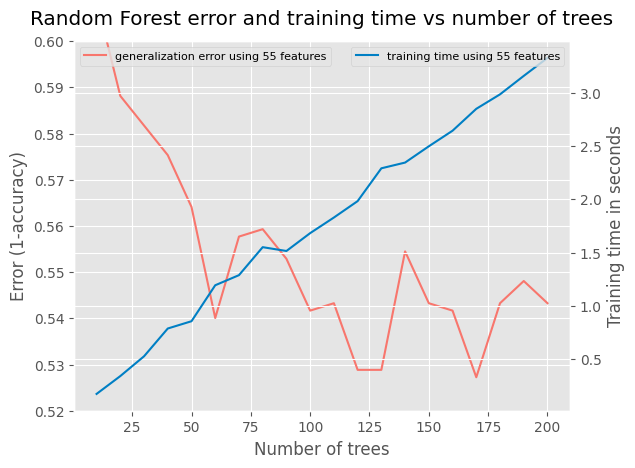

In [291]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range, errors, label = 'generalization error using 55 features', color = "#F8766D")
ax2.plot(n_estimators_range, tempi, label = 'training time using 55 features', color = "#007fc4")


plt.xlabel('Number of trees')
ax1.set_ylim(0.52, 0.60)
ax1.set_ylabel('Error (1-accuracy)')
ax2.set_ylabel('Training time in seconds')
plt.title('Random Forest error and training time vs number of trees', pad=12)
plt.style.use('ggplot')
ax1.legend(fontsize = 8, loc='upper left')
ax2.legend(fontsize = 8, loc='upper right')
ax1.set_xlabel('Number of trees')
plt.show()



### Errors of the model using the most important features

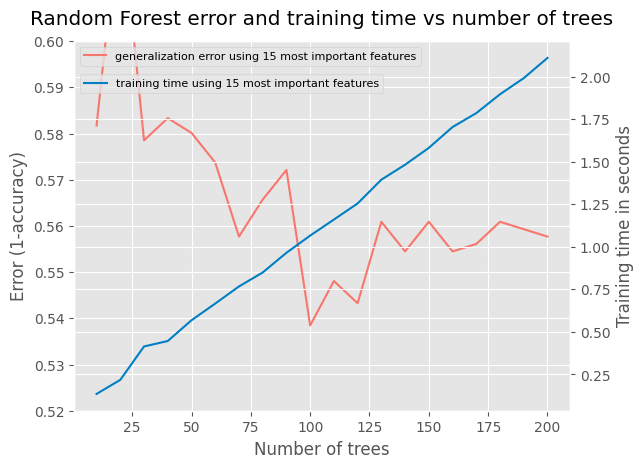

In [292]:
fig1, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range, errors_red, label = 'generalization error using 15 most important features', color = "#F8766D")
ax2.plot(n_estimators_range, tempi_red, label = 'training time using 15 most important features', color = "#007fc4")


plt.xlabel('Number of trees')
ax1.set_ylim(0.52, 0.60)
ax1.set_ylabel('Error (1-accuracy)')
ax2.set_ylabel('Training time in seconds')
plt.title('Random Forest error and training time vs number of trees', pad=12)
plt.style.use('ggplot')
ax1.legend(fontsize = 8, loc='upper left')
ax2.legend(fontsize = 8, loc=(0.012, 0.86))
ax1.set_xlabel('Number of trees')
plt.show()

In [162]:
# voglio plottare il decision boundary - 2 most import features
from matplotlib.colors import ListedColormap
markers = ['o', 's', '^', 'x', 'v', 'p', '*', 'd']
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w']
cmap = ListedColormap(colors)
# Ottenere le feature importance
importances = rfc.feature_importances_

# Ordinare le feature per importanza
indices = np.argsort(importances)[::-1]

# Selezionare le prime due feature
feature1, feature2 = df_train.columns[indices[0]], df_train.columns[indices[1]]
print("Le due feature più importanti sono la", feature1, "e la", feature2)

# Selezionare solo le colonne corrispondenti alle due feature più importanti
X_train_reduced = X_train[:, [indices[0], indices[1]]]
print(X_train_reduced)


Le due feature più importanti sono la mfcc_std_w2 e la mfcc_kur
[[ 1.13529755 -0.58494599]
 [ 1.23062421 -0.55303988]
 [ 1.2610991  -0.52462487]
 ...
 [ 0.09716676  1.07825009]
 [-0.42065978  1.49441562]
 [-0.20087885  2.11287837]]


C:\Users\Valeria\AppData\Local\Temp\ipykernel_13152\3938892747.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_train_reduced[y_train_encoded==cls, 0], X_train_reduced[y_train_encoded==cls, 1], c=cmap(i), label=emotions[cls], edgecolor='black')


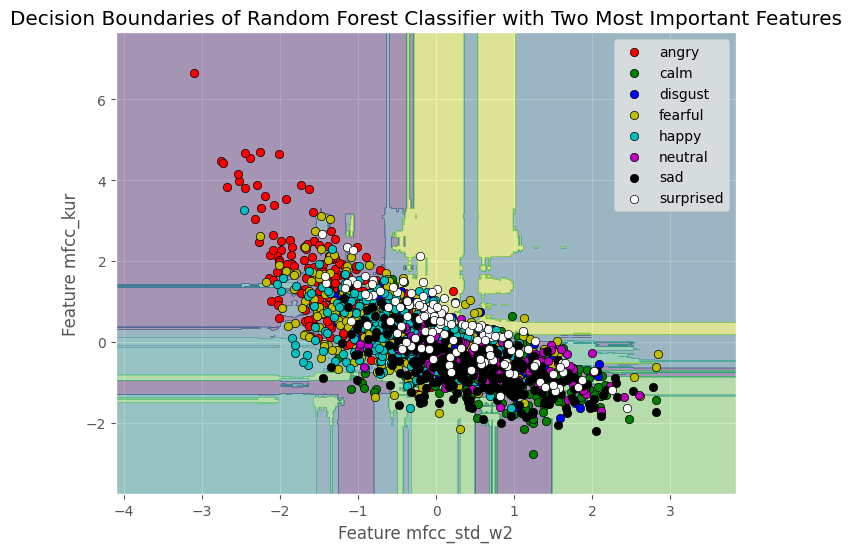

In [145]:
from sklearn.preprocessing import LabelEncoder

# Encode the categorical labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Fit the reduced model with encoded labels
rfc_reduced = RandomForestClassifier(class_weight=None, criterion='entropy', max_depth=54, max_features='sqrt', min_samples_leaf=2, min_samples_split=7, n_estimators=n_estimators)
rfc_reduced.fit(X_train_reduced, y_train_encoded)

plt.figure(figsize=(8, 6))
x_min, x_max = X_train_reduced[:, 0].min() - 1, X_train_reduced[:, 0].max() + 1
y_min, y_max = X_train_reduced[:, 1].min() - 1, X_train_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = rfc_reduced.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

emotions = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

plt.contourf(xx, yy, Z, alpha=0.4)
for i, cls in enumerate(np.unique(y_train_encoded)):
    plt.scatter(X_train_reduced[y_train_encoded==cls, 0], X_train_reduced[y_train_encoded==cls, 1], c=cmap(i), label=emotions[cls], edgecolor='black')
plt.xlabel('Feature ' + str(feature1))
plt.ylabel('Feature ' + str(feature2))
plt.title('Decision Boundaries of Random Forest Classifier with Two Most Important Features')
plt.legend()
plt.show()

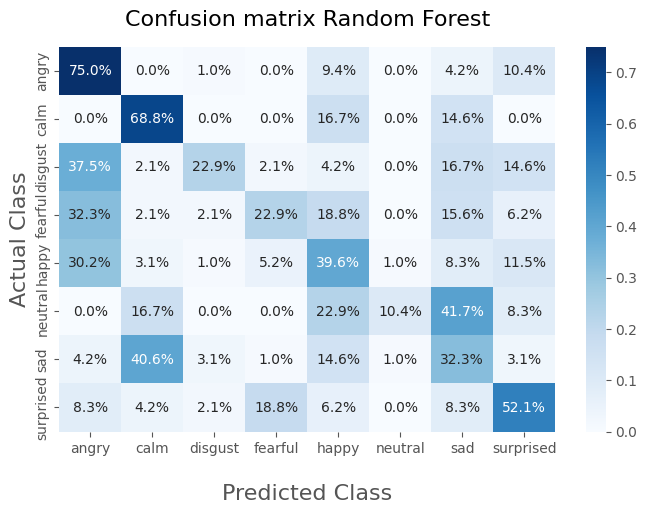

In [175]:
# confusion matrix + roc random forest 
from sklearn.metrics import confusion_matrix

cf_rf = confusion_matrix(y_test, y_pred3, normalize = 'true')
plt.figure(figsize = (8,5))
sns.heatmap(cf_rf, annot=True, cmap="Blues", xticklabels=rfc3.classes_, yticklabels = rfc3.classes_ ,  fmt='.1%')
plt.xlabel("\nPredicted Class", fontsize = 16)
plt.ylabel("Actual Class", fontsize = 16)
plt.title('Confusion matrix Random Forest', fontsize = 16, pad = 15)
plt.style.use('ggplot')
plt.show()

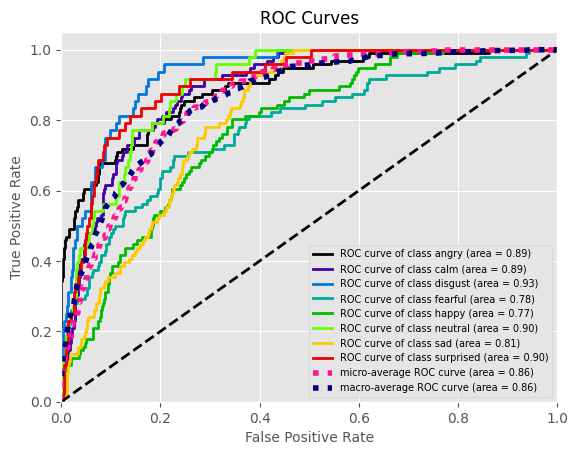

In [165]:
y_proba3 = rfc3.predict_proba(X_test_enc_norm)
plot_roc(y_test, y_proba3)
plt.legend(prop={'size':7})
plt.show()